# Metabolomics Case Study - Feature Extraction and Filtering
Jonathan E. Hunter, January 2025

In [1]:
# Initialize R magic (rpy2) for Jupyter Notebook
%load_ext rpy2.ipython 

### Import Python Libraries ###
# Import basic python data and plotting libraries
import pandas as pd

# Import pyopenms and deps.
import sys    

# Import NeatMS and deps.
import sys
import logging
import NeatMS as ntms
from  collections import Counter

# Import rpy2 and deps.
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

In [2]:
%%R
### Import R Libraries ###
library(xcms)
library(MsExperiment)
library(Spectra)
library(CAMERA)

Loading required package: BiocParallel
Loading required package: MSnbase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Loading required package: mzR
Loading required package: Rcpp
Loading required 

In [3]:
## Test GPU environment.
gpu = ! nvidia-smi
print("\n".join(gpu))

Tue Feb  4 16:25:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:0B:00.0  On |                  N/A |
| 52%   56C    P8             37W /  350W |    9034MiB /  24576MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
%%R
## XCMS Data Import and Initial EDA steps.
# Get the list of files in the ~/sync/Data directory
file_list <- list.files(path = "~/sync/Data/mzXML", full.names = TRUE)

# Define a data.frame with additional information on these files.
sample_metadata <- data.frame(file = basename(file_list),
                 sample = c("blank", "extract"))

# Import the data of the experiment
sample_data <- readMsExperiment(file_list, sampleData = sample_metadata)

# Subset the data
sample_data_blank <- sample_data[1]
sample_data_extract <- sample_data[2]

# Extract sample information
sampleData(sample_data_extract)

# Display sample spectra table
print(spectra(sample_data_blank))
print(spectra(sample_data_extract))


MSn data (Spectra) with 14158 spectra in a MsBackendMzR backend:
        msLevel     rtime scanIndex
      <integer> <numeric> <integer>
1             1   60.1037         1
2             1   60.5355         2
3             1   60.8529         3
4             1   61.1703         4
5             1   61.4918         5
...         ...       ...       ...
14154         2   1949.47     14154
14155         1   1949.60     14155
14156         2   1949.86     14156
14157         2   1949.97     14157
14158         2   1950.05     14158
 ... 33 more variables/columns.

file(s):
blank.mzXML
MSn data (Spectra) with 14163 spectra in a MsBackendMzR backend:
        msLevel     rtime scanIndex
      <integer> <numeric> <integer>
1             1   60.1130         1
2             1   60.5526         2
3             1   60.9003         3
4             1   61.2480         4
5             1   61.5684         5
...         ...       ...       ...
14159         2   1949.57     14159
14160         2   1949.6

In [5]:
%%R 
spectra(sample_data) |>
    spectraVariables()

 [1] "msLevel"                  "rtime"                   
 [3] "acquisitionNum"           "scanIndex"               
 [5] "dataStorage"              "dataOrigin"              
 [7] "centroided"               "smoothed"                
 [9] "polarity"                 "precScanNum"             
[11] "precursorMz"              "precursorIntensity"      
[13] "precursorCharge"          "collisionEnergy"         
[15] "isolationWindowLowerMz"   "isolationWindowTargetMz" 
[17] "isolationWindowUpperMz"   "peaksCount"              
[19] "totIonCurrent"            "basePeakMZ"              
[21] "basePeakIntensity"        "ionisationEnergy"        
[23] "lowMZ"                    "highMZ"                  
[25] "mergedScan"               "mergedResultScanNum"     
[27] "mergedResultStartScanNum" "mergedResultEndScanNum"  
[29] "injectionTime"            "filterString"            
[31] "spectrumId"               "ionMobilityDriftTime"    
[33] "scanWindowLowerLimit"     "scanWindowUpperLimit"  

In [6]:
%%R
print("Blank - spectra per MS level") 
print(table(spectra(sample_data_blank)$msLevel))
    
print("Extract - spectra per MS level") 
print(table(spectra(sample_data_extract)$msLevel))

[1] "Blank - spectra per MS level"

    1     2 
 2401 11757 
[1] "Extract - spectra per MS level"

    1     2 
 2377 11786 


In [7]:
%%R
# Get the distribution of peak counts per spectrum.
spectra(sample_data) |>
    lengths() |>
    split(fromFile(sample_data)) |>
    lapply(quantile)

$`1`
     0%     25%     50%     75%    100% 
   3.00   16.00   25.00   38.75 2635.00 

$`2`
  0%  25%  50%  75% 100% 
   2   21   36   68 2435 



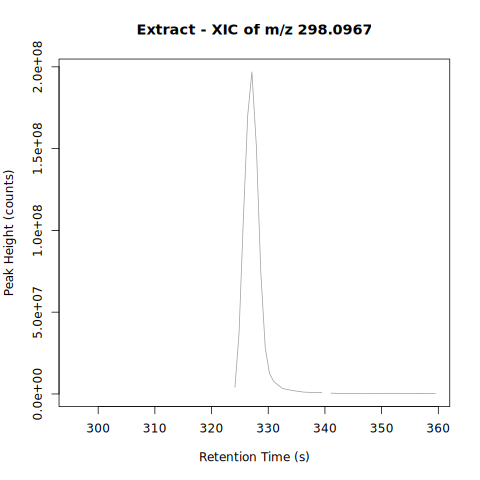

In [8]:
%%R
target_chr <- chromatogram(sample_data, mz = 298.0967 + c(-0.001, 0.001), aggregationFun = "max", msLevel = 1, rt = c(295, 360))
plot(target_chr, main="Extract - XIC of m/z 298.0967", xlab="Retention Time (s)", ylab="Peak Height (counts)")

Object of class:  CentWaveParam 
 Parameters:
 - ppm: [1] 25
 - peakwidth: [1] 20 50
 - snthresh: [1] 10
 - prefilter: [1]   3 100
 - mzCenterFun: [1] "wMean"
 - integrate: [1] 1
 - mzdiff: [1] -0.001
 - fitgauss: [1] FALSE
 - noise: [1] 0
 - verboseColumns: [1] FALSE
 - roiList: list()
 - firstBaselineCheck: [1] TRUE
 - roiScales: numeric(0)
 - extendLengthMSW: [1] FALSE
Object of class:  CentWaveParam 
 Parameters:
 - ppm: [1] 15
 - peakwidth: [1]  2 10
 - snthresh: [1] 20
 - prefilter: [1]   3 100
 - mzCenterFun: [1] "wMean"
 - integrate: [1] 2
 - mzdiff: [1] -0.001
 - fitgauss: [1] FALSE
 - noise: [1] 5e+05
 - verboseColumns: [1] FALSE
 - roiList: list()
 - firstBaselineCheck: [1] TRUE
 - roiScales: numeric(0)
 - extendLengthMSW: [1] FALSE
          rt   rtmin   rtmax      into      intb      maxo  sn row column
[1,] 327.116 323.368 337.867 620867875 617817739 196899632 700   1      2


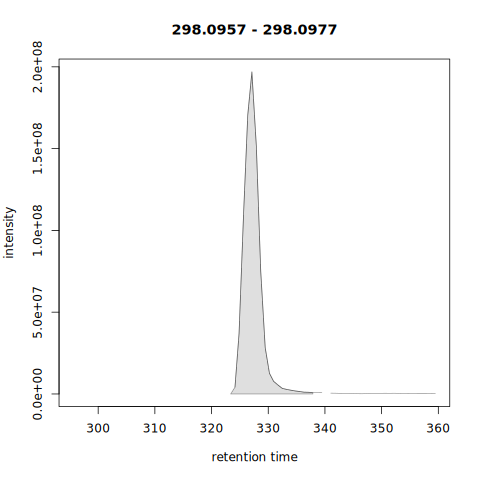

In [9]:
%%R
## XCMS Determine and set centWave peak detection parameters
# Get default centWave parameters
cwp <- CentWaveParam()

# "dry-run" peak detection on the EIC.
res <- findChromPeaks(target_chr, param = cwp)
chromPeaks(res)

# Default centWave parameters
print(cwp)

# Plot the EIC
plot(target_chr)

# Adapt centWave parameters
cwp <- CentWaveParam(peakwidth = c(2, 10), integrate = 2, ppm = 15, noise = 500000, snthresh = 20)
print(cwp)

# Run peak detection on the EIC
target_chr <- findChromPeaks(target_chr, param = cwp)

# Plot the data and higlight identified peak area
plot(target_chr)

# Extract identified chromatographic peaks from the EIC
chromPeaks(target_chr)

In [10]:
%%R
## XCMS Peak Detection
#' Perform peak detection on the full data set
sample_data <- findChromPeaks(sample_data, param = cwp)
sample_data

Object of class XcmsExperiment 
 Spectra: MS1 (4778) MS2 (23543) 
 Experiment data: 2 sample(s)
 Sample data links:
  - spectra: 2 sample(s) to 28321 element(s).
 xcms results:
  - chromatographic peaks: 5819 in MS level(s): 1 


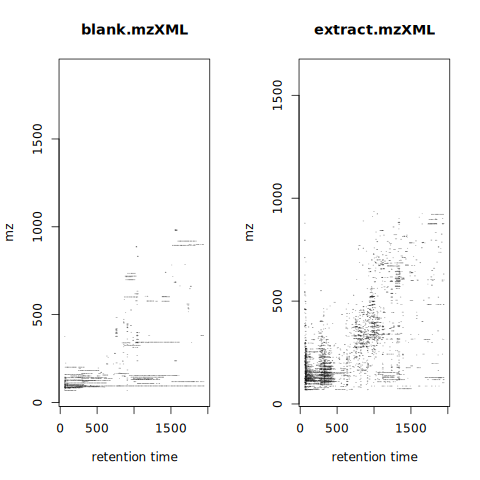

In [11]:
%%R
## XCMS 2D maps
#' Count peaks per file
table(chromPeaks(sample_data)[, "sample"])

#' Plot the location of peaks in the m/z - rt plane
par(mfrow = c(1, 2))
plotChromPeaks(sample_data, 1)
plotChromPeaks(sample_data, 2)

          rtmin    rtmax     mzmin     mzmax
CP4871 1051.140 1080.730 320.29804 320.30807
CP0442  284.645  306.251 150.96389 150.97390
CP3837  343.886  375.174 147.06025 147.07029
CP0254  160.189  188.194  85.02405  85.03406


Processing chromatographic peaks


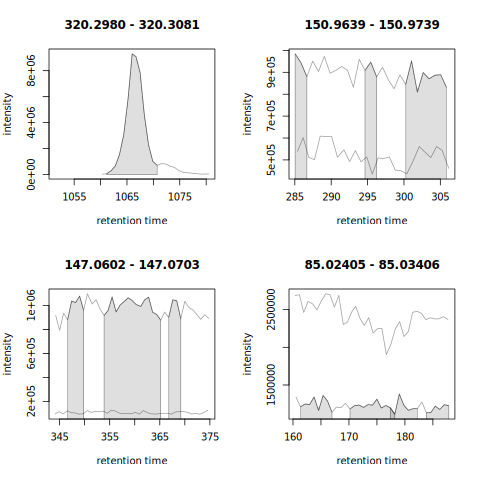

In [12]:
%%R
## XCMS Evaluate Peak Detection
#' Select 4 random peaks
npeaks <- nrow(chromPeaks(sample_data))
idx <- sample(seq_len(npeaks), 4)

#' Extract m/z-rt regions for 4 random peaks
mz_rt <- chromPeaks(sample_data)[idx, c("rtmin", "rtmax", "mzmin", "mzmax")]

#' Expand the rt range by 10 seconds on both sides
mz_rt[, "rtmin"] <- mz_rt[, "rtmin"] - 10
mz_rt[, "rtmax"] <- mz_rt[, "rtmax"] + 10
#' Expand the m/z range by 0.005 on both sides
mz_rt[, "mzmin"] <- mz_rt[, "mzmin"] - 0.005
mz_rt[, "mzmax"] <- mz_rt[, "mzmax"] + 0.005

#' Display the randomly selected regions
print(mz_rt)

#' Define m/z - retention time regions for EICs
# mz_rt <- rbind(c(106.045, 106.055, 165, 195),
#                c(132.096, 132.107, 135, 160),
#                c(125.981, 125.991, 195, 215),
#                c(105.468, 105.478, 190, 215))

#' Extract the EICs
eics <- chromatogram(sample_data, mz = mz_rt[, c("mzmin", "mzmax")], rt = mz_rt[, c("rtmin", "rtmax")])
#' Plot the EICs
plot(eics)

## data very noisy when picking random peaks at 100K threshold, trying 200K

XChromatograms with 4 rows and 2 columns
                   1               2
     <XChromatogram> <XChromatogram>
[1,]        peaks: 0        peaks: 1
[2,]        peaks: 1        peaks: 0
[3,]        peaks: 0        peaks: 1
[4,]        peaks: 1        peaks: 0
phenoData with 3 variables
featureData with 4 variables
- - - xcms preprocessing - - -
Chromatographic peak detection:
 method: centWave 


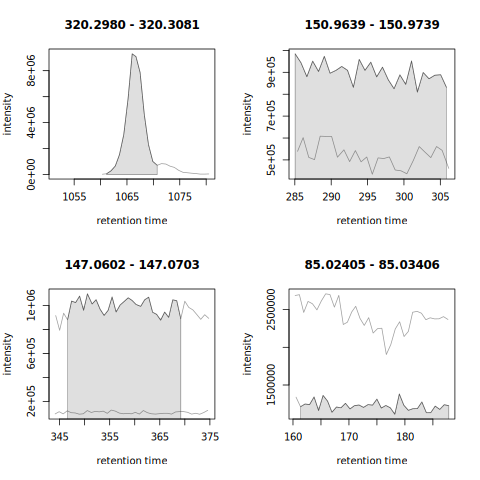

In [13]:
%%R
## XCMS Peak Refinement - Inital Tests
# Define the setting for the peak refinement
mpp <- MergeNeighboringPeaksParam(expandRt = 4, minProp = 0.75)

# Perform the peak refinement on the EICs
eics <- refineChromPeaks(eics, param = mpp)

# Plot the results
plot(eics)
eics

# I've let it overpick junk peaks here on the basis that NeatMS will filter peak shapes more effectively later on.

In [14]:
%%R
## XCMS Peak Refinement - Full Data Set
# Perform peak refinement on the full data set
sample_data <- refineChromPeaks(sample_data, param = mpp)

chromPeaks(sample_data)[, "sample"] |>
    table()

# No. of merged peaks    
sum(chromPeakData(sample_data)$merged)

[1] 921


Reduced from 5819 to 3441 chromatographic peaks.


In [15]:
%%R
# XCMS Initial Peak Grouping

# Define the parameters for the peak density estimation
pdp <- PeakDensityParam(sampleGroups = c(0, 1), bw = 1.8,
                        minFraction = 0, binSize = 0.01)
sample_data <- groupChromPeaks(sample_data, pdp)

# Get the anchor peaks that would be selected
pgm <- adjustRtimePeakGroups(sample_data, PeakGroupsParam(minFraction = 1))

Performing retention time correction using 3373 peak groups.


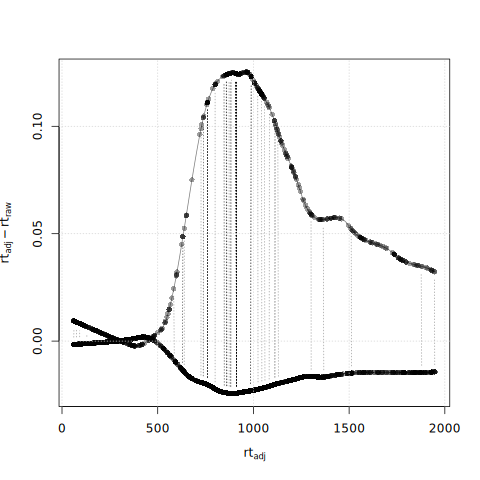

In [16]:
%%R
# XCMS RT Correction

# Define settings for the alignment
pgp <- PeakGroupsParam(minFraction = 0.5, span = 0.6)
sample_data <- adjustRtime(sample_data, param = pgp)

# Plot the difference between raw and adjusted retention times
plotAdjustedRtime(sample_data)
grid()

In [17]:
%%R
## XCMS Correspondence Analysis
# Set parameters for correspondence analysis.
pdp <- PeakDensityParam(sampleGroups = c(0, 1), bw = 1.8,
                        minFraction = 0, binSize = 0.005)

# Perform the correspondence analysis on the full data
sample_data <- groupChromPeaks(sample_data, param = pdp)

# Definition of the features
featureDefinitions(sample_data) |>
    head()
    
# Get abundances for the first 6 features
featureValues(sample_data, method = "sum") |>
    head()

       blank.mzXML extract.mzXML
FT0001          NA      14647620
FT0002          NA      26600300
FT0003          NA       2629211
FT0004     9238292       7994443
FT0005    80174981       7903664
FT0006          NA    3151122272


In [18]:
%%R
## Prepare the XCMS feature and peak data for export to Python.

# Extract feature definitions and values
feature_defs <- featureDefinitions(sample_data)
feature_vals <- featureValues(sample_data, value = "into")

# Convert feature definitions and values to data frames
feature_defs_df <- as.data.frame(feature_defs)

# Unpack the peakidx column into two new columns
list_cols <- do.call(rbind, feature_defs_df$peakidx)

# Combine with original DataFrame
feature_defs_df <- cbind(feature_defs_df, list_cols)

# Rename the new columns
colnames(feature_defs_df)[(ncol(feature_defs_df)-1):ncol(feature_defs_df)] <- c("peakidx_1", "peakidx_2")

# Drop original peakidx column
feature_defs_df <- feature_defs_df[, !colnames(feature_defs_df) %in% "peakidx"]

# Convert feature values and peak data to data frames
feature_vals_df <- as.data.frame(feature_vals)
peak_data_df <- as.data.frame(chromPeaks(sample_data))

# Create a key variable to pair features with peaks.
all_peak_ids <- lapply(featureDefinitions(sample_data)$peakidx, function(peak_indices) {
  rownames(chromPeaks(sample_data))[peak_indices]})
all_peak_ids <- as.data.frame(all_peak_ids)

In [19]:
# Define function to import R data frames to Python and convert to pandas
def r_df_to_pandas(r_df_name):
    df_R = ro.r(r_df_name)
    with (ro.default_converter + pandas2ri.converter).context():
        df_pandas = ro.conversion.get_conversion().rpy2py(df_R)
    return df_pandas

# Import the R data frames to pandas data frames
peak_data_df_py = r_df_to_pandas("peak_data_df")
feature_vals_df_py = r_df_to_pandas("feature_vals_df")
feature_defs_df_py = r_df_to_pandas("feature_defs_df")
all_peak_ids_df_py = r_df_to_pandas("all_peak_ids")
all_peak_ids_df_py = all_peak_ids_df_py.transpose().reset_index(drop=True)

# Combine index with sample id to de-duplicate ahead of pivot.
peak_data_df_py["index_sample"] = peak_data_df_py.index.astype(str) + "_" + peak_data_df_py["sample"].astype(str)

# Define function to pivot peak data
def pivot_peak_data(peak_data_df, values):
    mz_peak_data = peak_data_df.pivot(index='sample', columns='index_sample', values=values)
    mz_peak_data = (mz_peak_data.head(2).transpose().reset_index())
    mz_peak_data.rename(columns={1.0: "blank.mzXML", 2.0: "extract.mzXML"}, inplace=True)
    mz_peak_data["index_sample"] = mz_peak_data["index_sample"].str.split("_").str[0]
    return mz_peak_data

# Pivot the peak data
mz_peak_data = pivot_peak_data(peak_data_df_py, 'mz')
mz_min_peak_data = pivot_peak_data(peak_data_df_py, 'mzmin')
mz_max_peak_data = pivot_peak_data(peak_data_df_py, 'mzmax')
rt_peak_data = pivot_peak_data(peak_data_df_py, 'rt')
rt_start_peak_data = pivot_peak_data(peak_data_df_py, 'rtmin')
rt_end_peak_data = pivot_peak_data(peak_data_df_py, 'rtmax')
peak_height = pivot_peak_data(peak_data_df_py, 'maxo')
peak_area = pivot_peak_data(peak_data_df_py, 'into')

In [20]:
# Due to the the migration of xcms to the use of the XcmsExperiment rather than the older XCMSnExp class, the data can no longer be read directly by NeatMS.
# The data must be converted to the format expected by NeatMS, in this case the MZMine2 format.

# Import the mz and rt data from the feature definitions and rename the columns to match the MZMine2 format.
xcms_to_neatms = feature_defs_df_py[["mzmed", "rtmed"]].rename(columns={"mzmed" : "row m/z", "rtmed" : "row retention time"})

# Merge in feature:peak key.
xcms_to_neatms = xcms_to_neatms.reset_index(drop=True)
xcms_to_neatms = xcms_to_neatms.merge(all_peak_ids_df_py, left_index=True, right_index=True, how="left")
xcms_to_neatms.rename(columns={"1": "peak blank.mzXML", "2": "peak extract.mzXML"}, inplace=True)

# Map peak vaules to the xcms_to_neatms dataframe
def map_peak_values(df, peak_data, peak_column):
    return df[f"peak {peak_column}"].map(peak_data.set_index("index_sample")[peak_column])

peak_mapping_params = {
    "blank.mzML Peak m/z": ("mz_peak_data", "blank.mzXML"),
    "blank.mzML Peak RT": ("rt_peak_data", "blank.mzXML"),
    "blank.mzML Peak RT start": ("rt_start_peak_data", "blank.mzXML"),
    "blank.mzML Peak RT end": ("rt_end_peak_data", "blank.mzXML"),
    "blank.mzML Peak height": ("peak_height", "blank.mzXML"),
    "blank.mzML Peak area": ("peak_area", "blank.mzXML"),
    "blank.mzML Peak m/z min": ("mz_min_peak_data", "blank.mzXML"),
    "blank.mzML Peak m/z max": ("mz_max_peak_data", "blank.mzXML"),
    "extract.mzML Peak m/z": ("mz_peak_data", "extract.mzXML"),
    "extract.mzML Peak RT": ("rt_peak_data", "extract.mzXML"),
    "extract.mzML Peak RT start": ("rt_start_peak_data", "extract.mzXML"),
    "extract.mzML Peak RT end": ("rt_end_peak_data", "extract.mzXML"),
    "extract.mzML Peak height": ("peak_height", "extract.mzXML"),
    "extract.mzML Peak area": ("peak_area", "extract.mzXML"),
    "extract.mzML Peak m/z min": ("mz_min_peak_data", "extract.mzXML"),
    "extract.mzML Peak m/z max": ("mz_max_peak_data", "extract.mzXML")
}

for col, (peak_data, peak_column) in peak_mapping_params.items():
    xcms_to_neatms[col] = map_peak_values(xcms_to_neatms, eval(peak_data), peak_column)

# Drop peak ID columns
xcms_to_neatms.drop(columns=["peak blank.mzXML", "peak extract.mzXML"], inplace=True)

#Convert RT columns to mins
def convert_rt_to_minutes(df, rt_columns):
    for col in rt_columns:
        df[col] = df[col] / 60
    return df

rt_columns = [
    "blank.mzML Peak RT", 
    "blank.mzML Peak RT start", 
    "blank.mzML Peak RT end",
    "extract.mzML Peak RT", 
    "extract.mzML Peak RT start", 
    "extract.mzML Peak RT end"
]

xcms_to_neatms = convert_rt_to_minutes(xcms_to_neatms, rt_columns)

# Save the dataframe to a CSV file
xcms_to_neatms.to_csv("sync/Output/xcms_to_neatms.csv", index=False)

In [21]:
## NeatMS
# Setting log output (Jupyter notebook specific)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

# Create experiment object and load data
raw_data_folder_path = 'sync/Data/mzML'
# Using peaks that have been aligned across samples
feature_table_path = 'sync/Output/xcms_to_neatms.csv'
# Using unaligned peaks (One individual peak table for each sample)
# feature_table_path = '../data/test_data/unaligned_features/'
# This is important for NeatMS to read the feature table correctly
input_data = 'mzmine'

experiment = ntms.Experiment(raw_data_folder_path, feature_table_path, input_data)

# Data exploration
for sample in experiment.samples:
    print('Sample {} : {} peaks'.format(sample.name,len(sample.feature_list)))

exp = experiment
sizes = []
print("# Feature collection:",len(exp.feature_tables[0].feature_collection_list))

for consensus_feature in exp.feature_tables[0].feature_collection_list:
    sizes.append(len(consensus_feature.feature_list))

c = Counter(sizes)
print("Number of consensus features:")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list)) 

# Neural network handler object
nn_handler = ntms.NN_handler(experiment)

# Load model
# Adjust the model path (relative and absolute path are both accepted)
# Note that model #2 has been tuned to a specific dataset using transfer learning
# Here we use the first default base model
model_path = "sync/NeatMS/data/model/neatms_default_model.h5"
nn_handler.create_model(model = model_path)

2025-02-04 16:25:58,841 | INFO : Data reader backend: pymzml
2025-02-04 16:25:58,842 | INFO : Loading file 1 / 2
2025-02-04 16:25:58,842 | INFO : Loading file 2 / 2
2025-02-04 16:25:58,847 | INFO : Loading feature table: /home/dockeruser/sync/Output/xcms_to_neatms.csv
2025-02-04 16:25:58,847 | INFO : Feature table format: MZmine
2025-02-04 16:25:58,847 | INFO : Loading feature table and converting format
2025-02-04 16:25:58,968 | INFO : Loading 3374 features and 3439 peaks 
2025-02-04 16:25:59,485 | INFO : Feature table loaded with success
Sample blank : 540 peaks
Sample extract : 2899 peaks
# Feature collection: 3375
Number of consensus features:
   of size  1 :   3311
   of size  2 :     64
        total :   3375


2025-02-04 16:25:59.833573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738686359.853711     835 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738686359.858635     835 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 16:25:59.886760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-02-04 16:26:02,997 | INFO : Using existing model: /home/dockeruser/sync/NeatMS/data/model/neatms_default_model.h5


I0000 00:00:1738686363.396772     835 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6


2025-02-04 16:26:05,623 | WARNING : Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2025-02-04 16:26:05,636 | WARNING : Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


/home/dockeruser/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
## NeatMS
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

# Exploring results
exp = experiment
hq_sizes = []
lq_sizes = []
n_sizes = []
sizes = []
print("# Feature collection:",len(exp.feature_tables[0].feature_collection_list))
for consensus_feature in exp.feature_tables[0].feature_collection_list:
    hq_size = 0
    lq_size = 0
    n_size = 0
    for feature in consensus_feature.feature_list:
        for peak in feature.peak_list:
            if peak.valid:
                if peak.prediction.label == "High_quality":
                    hq_size += 1
                if peak.prediction.label == "Low_quality":
                    lq_size += 1
                if peak.prediction.label == "Noise":
                    n_size += 1

    hq_sizes.append(hq_size)
    lq_sizes.append(lq_size)
    n_sizes.append(n_size)
    sizes.append(len(consensus_feature.feature_list))

c = Counter(hq_sizes)
print("\nNumber of consensus features labeled as 'High quality':")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list))

c = Counter(lq_sizes)
print("\nNumber of consensus features labeled as 'Low quality':")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list))

c = Counter(n_sizes)
print("\nNumber of consensus features labeled as 'Noise':")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list))

# Export results
filename = 'sync/Output/neatms_export.csv'

export_params = {
    "export_classes" : ["High_quality", "Low_quality", "Noise"],
    "min_group_classes" : ["High_quality", "Low_quality", "Noise"],
    "min_group_size" : 0
}

experiment.export_csv(filename, **export_params)

2025-02-04 16:26:05,650 | INFO : Predicting peaks from 2 samples
2025-02-04 16:26:05,651 | INFO : Extracting and formatting peak chromatograms for sample: blank
2025-02-04 16:26:11,700 | INFO : Predicting 437 peaks


I0000 00:00:1738686371.803490     969 service.cc:148] XLA service 0x7f1f84007010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738686371.803583     969 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-04 16:26:11.815315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738686371.843196     969 cuda_dnn.cc:529] Loaded cuDNN version 90700


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

I0000 00:00:1738686371.788741     969 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
2025-02-04 16:26:12,501 | INFO : Extracting and formatting peak chromatograms for sample: extract
2025-02-04 16:26:20,168 | INFO : Predicting 2147 peaks
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
# Feature collection: 3375

Number of consensus features labeled as 'High quality':
   of size  0 :   2396
   of size  1 :    959
   of size  2 :     20
        total :   3375

Number of consensus features labeled as 'Low quality':
   of size  0 :   2786
   of size  1 :    589
        total :   3375

Number of consensus features labeled as 'Noise':
   of size  0 :   2389
   of size  1 :    976
   of size  2 :     10
        total :   3375
2025-02-04 16:26:21,141 | INFO : Exporting data to /home/dockeruser/sync/Output/neatms_export.csv


In [23]:
%%R
## CAMERA
# Convert 'XcmsExperiment' to xset class
xset <- as(sample_data, "xcmsSet")

#CAMERA
#Create an xsAnnotate object
xsa <- xsAnnotate(xset)
#Group after RT value of the xcms grouped peak
xsaF <- groupFWHM(xsa, perfwhm=0.6)
#Verify grouping
xsaC <- groupCorr(xsaF)
#Annotate isotopes, could be done before groupCorr
xsaFI <- findIsotopes(xsaC)
#Annotate adducts
xsaFA <- findAdducts(xsaFI, polarity="positive")
#Get final peaktable and store on harddrive
write.csv(getPeaklist(xsaFA),file="sync/Output/result_CAMERA.csv")

Start grouping after retention time.
Created 532 pseudospectra.
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 532 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 532 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1838 
xsAnnotate has now 1838 groups, instead of 532 
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 296 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1838 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


Note: you might want to set/adjust the 'sampclass' of the returned xcmSet object before proceeding with the analysis.


In [24]:
%%R
# Assuming 'xdata' is your XCMSnExp object with grouped chromatographic peaks
features <- featureDefinitions(sample_data)

# Display the first few features with their median m/z and retention times
features_all <- (features[, c("mzmed", "rtmed")])


In [25]:
# Export all XCMS features to pandas DF for diagnostic purposes.
#all_xcms_features = r_df_to_pandas("features_all")

In [26]:
# Load the NeatMS results from csv.
neatms_results = pd.read_csv("sync/Output/neatms_export.csv")
neatms_results = neatms_results.drop(columns=["Unnamed: 0"])
neatms_results.rename(columns={"m/z": "mz", "retention time": "rt"}, inplace=True)

# Round m/z and rt columns to 7 decimal places, for coherence with CAMERA results.
neatms_results["rt"] = neatms_results["rt"].round(7)
neatms_results["mz"] = neatms_results["mz"].round(7)
neatms_results["feature ID"] = neatms_results["feature ID"]                         # NeatMS first feature is missing?

# Load the CAMERA results from csv.
CAMERA_results = pd.read_csv("sync/Output/result_CAMERA.csv")
CAMERA_results.rename(columns={"Unnamed: 0": "feature ID", "X0":"blank", "X1":"extract", "X1.1":"I_blank", "X2":"I_extract"}, inplace=True)

# Round m/z and rt columns to 7 decimal places, for coherence with NeatMS results.
CAMERA_results["rt"] = CAMERA_results["rt"].round(7)
CAMERA_results["mz"] = CAMERA_results["mz"].round(7)

# Merge the CAMERA and NeatMS results into a single dataframe.
# Take the feature IDs from CAMERA as something has gone wonky with NeatMS as a result of the MZMine2 format fudge. First feature is missing, fix later.
results_merged = neatms_results.merge(CAMERA_results, on=["mz", "rt"], how="right")  
results_merged = results_merged.drop(columns=["feature ID_x"])
results_merged.rename(columns={"feature ID_y":"feature ID"}, inplace=True)

print(f"Length CAMERA Results: {len(CAMERA_results)}")
print(f"Length NeatMS Results: {len(neatms_results)}")
print(f"Length Merged Results: {len(results_merged)}")


Length CAMERA Results: 3375
Length NeatMS Results: 2584
Length Merged Results: 3409


In [27]:
# Filter and select data:
results_selected = results_merged[results_merged["label"] == "High_quality"]        # Filter for "High_quality" labelled (NeatMS) peaks.
results_selected_ext = results_selected[results_selected["extract"] == 1]               # Filter for peaks present in the extract sample.
results_selected_ext_sort = results_selected_ext.sort_values(by="I_extract", ascending=False)    # Sort by intensity in the extract sample.

# Generate boolean Series for samples where peak in blank is > 10% of peak in extract.
blank_exceeds_10pc = (results_selected_ext_sort["blank"] == 1) & (results_selected_ext_sort["extract"] == 1) & (results_selected_ext_sort["I_extract"] < (results_selected_ext_sort["I_blank"] * 10)) 
blank_exceeds_10pc_inverted = ~blank_exceeds_10pc                                   # Invert the boolean Series
results_selected_final = results_selected_ext_sort[blank_exceeds_10pc_inverted]                    # Filter out peaks where blank is > 10% of extract                                       # Select top all peaks by intensity

# Format feature ID list and pass to R environment.
feature_targets_py = results_selected_final["feature ID"]                                 # Extract feature target IDs

def add_leading_zeros(num):
    return str(num).zfill(4)

feature_targets_py = feature_targets_py.apply(add_leading_zeros)                    # Add leading zeros to feature target IDs in line with other XCMS objects.
feature_targets_py = "FT"+feature_targets_py                                        # Add 'FT' prefix to feature target IDs in line with other XCMS objects.
feature_targets_py = feature_targets_py.tolist()            
#feature_targets_py_out = feature_targets_py.copy()                                 # Create a copy of the feature target list for diagnostic purposes.
feature_targets_py = ro.StrVector(feature_targets_py)                               # Convert to R vector
ro.globalenv['feature_targets_R'] = feature_targets_py                              # Pass feature target list to R environment

In [28]:
%%R
# Extract MS2 spectra, closest in RT to precursor peak apex, for the selected features.
ms2_spectra_selected <- featureSpectra(sample_data, msLevel = 2L, features = feature_targets_R, method = "closest_rt")
print(head(ms2_spectra_selected))
first_spectrum <- ms2_spectra_selected[1]
print(spectraData(first_spectrum))

# Export the selected MS2 spectra to an MGF file.
library(MsBackendMgf)
export(
  ms2_spectra_selected,
  MsBackendMgf(),
  file = "sync/Output/extract_MS2_spectra_FULL.mgf"
)

MSn data (Spectra) with 6 spectra in a MsBackendMzR backend:
    msLevel     rtime scanIndex
  <integer> <numeric> <integer>
1         2 1316.1734      9435
2         2 1119.4500      7977
3         2   80.6900       141
4         2 1345.3832      9657
5         2   78.9069       127
6         2 1234.6727      8829
 ... 35 more variables/columns.

file(s):
extract.mzXML
Processing:
 Filter: select MS level(s) 2 [Tue Feb  4 16:26:46 2025]
 Merge 2 Spectra into one [Tue Feb  4 16:26:47 2025] 
DataFrame with 1 row and 36 columns
    msLevel     rtime acquisitionNum scanIndex   dataStorage    dataOrigin
  <integer> <numeric>      <integer> <integer>   <character>   <character>
1         2   1316.17           9435      9435 /home/dock... /home/dock...
  centroided  smoothed  polarity precScanNum precursorMz precursorIntensity
   <logical> <logical> <integer>   <integer>   <numeric>          <numeric>
1       TRUE        NA         1        9434       571.4          678215296
  precursorChar